In [9]:
# install setuptools to provide pkg_resources (fix ModuleNotFoundError in Jupyter)
%pip install setuptools
# install pandas
%pip install pandas
# install vnstock
%pip install vnstock

%pip install statsmodels
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [7]:
import json
from pathlib import Path
from datetime import datetime, timedelta
import pandas as pd
from vnstock import Quote

# Paths
ROOT = Path(__file__).parent if '__file__' in globals() else Path('.')
VN30_JSON = ROOT / 'vn30.json'
OUT_DIR = ROOT
OUT_DIR.mkdir(exist_ok=True)

# Read VN30 symbols from vn30.json
with open(VN30_JSON, 'r', encoding='utf-8') as f:
    vn30 = json.load(f)

# Determine date range: last 30 calendar days (for trading days we still request 30 days and rely on available data)
end_dt = datetime.now()
start_dt = end_dt - timedelta(days=30)
start_str = start_dt.strftime('%Y-%m-%d')
end_str = end_dt.strftime('%Y-%m-%d')
# Safe filename-friendly timestamps (no colons)
start_str_safe = start_dt.strftime('%Y%m%dT%H%M%S')
end_str_safe = end_dt.strftime('%Y%m%dT%H%M%S')

# Helper to fetch a symbol's DataFrame (we'll collect and concat later)
def fetch_symbol_df(symbol):
    q = Quote(symbol=symbol)
    print(f"Fetching {symbol} from {start_str} to {end_str}")
    # interval '1H' requests 1-hour data. vnstock expects interval argument like '1H' (string).
    df = q.history(start=start_str, end=end_str, interval='1H')
    if isinstance(df, pd.DataFrame) and not df.empty:
        # Ensure datetime index where possible
        try:
            df.index = pd.to_datetime(df.index)
        except Exception:
            pass
        df = df.copy()
        df['stock_symbol'] = symbol
        return df
    else:
        print(f"No data for {symbol} in range {start_str} - {end_str}")
        return None

# vn30 has a fixed structure: 'stocks' is a list of objects with a 'symbol' key
symbols = [entry['symbol'].strip() for entry in vn30['stocks']]

# Fetch sequentially (you can parallelize if desired). Collect DataFrames.
collected = []
for sym in symbols:
    df_sym = fetch_symbol_df(sym)
    if df_sym is not None:
        collected.append(df_sym)

# Concatenate and save one combined CSV
if collected:
    all_df = pd.concat(collected, axis=0, ignore_index=False)
    # If index is datetime, move it to a 'timestamp' column
    try:
        if isinstance(all_df.index, pd.DatetimeIndex):
            all_df = all_df.reset_index().rename(columns={'index': 'timestamp'})
        else:
            all_df = all_df.reset_index().rename(columns={'index': 'timestamp'})
    except Exception:
        all_df = all_df.reset_index().rename(columns={'index': 'timestamp'})

    out_file = OUT_DIR / f"vn30.csv"
    all_df.to_csv(out_file, index=False)
    print(f"Saved combined CSV -> {out_file} (rows={len(all_df)})")
else:
    print("No data collected for any symbol.")

Fetching VCB from 2025-08-19 to 2025-09-18
Fetching VIC from 2025-08-19 to 2025-09-18
Fetching VHM from 2025-08-19 to 2025-09-18
Fetching VIC from 2025-08-19 to 2025-09-18
Fetching VHM from 2025-08-19 to 2025-09-18
Fetching BID from 2025-08-19 to 2025-09-18
Fetching BID from 2025-08-19 to 2025-09-18
Fetching TCB from 2025-08-19 to 2025-09-18
Fetching TCB from 2025-08-19 to 2025-09-18
Fetching CTG from 2025-08-19 to 2025-09-18
Fetching CTG from 2025-08-19 to 2025-09-18
Fetching VPB from 2025-08-19 to 2025-09-18
Fetching VPB from 2025-08-19 to 2025-09-18
Fetching HPG from 2025-08-19 to 2025-09-18
Fetching HPG from 2025-08-19 to 2025-09-18
Fetching GAS from 2025-08-19 to 2025-09-18
Fetching FPT from 2025-08-19 to 2025-09-18
Fetching GAS from 2025-08-19 to 2025-09-18
Fetching FPT from 2025-08-19 to 2025-09-18
Fetching MBB from 2025-08-19 to 2025-09-18
Fetching MBB from 2025-08-19 to 2025-09-18
Fetching GVR from 2025-08-19 to 2025-09-18
Fetching VNM from 2025-08-19 to 2025-09-18
Fetching GV

In [11]:
# New cell appended: compute CAPM alpha and beta for each stock (cleaned/fixed)
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import datetime
import statsmodels.api as sm

ROOT = Path('.')
VN30_CSV = ROOT / 'vn30.csv'

# Read CSV
if not VN30_CSV.exists():
    raise FileNotFoundError(f"Expected {VN30_CSV} to exist. Run the earlier cell that saves the combined CSV first.")

df = pd.read_csv(VN30_CSV, parse_dates=['timestamp'])

# Validate required columns
required_cols = {'timestamp', 'close', 'stock_symbol'}
missing = required_cols - set(df.columns)
if missing:
    raise ValueError(f"Input CSV missing columns: {missing}")

# Sort and pivot prices to have timestamps as index and symbols as columns
price_df = df[['timestamp', 'stock_symbol', 'close']].copy()
price_df['timestamp'] = pd.to_datetime(price_df['timestamp'])
price_pivot = price_df.pivot_table(index='timestamp', columns='stock_symbol', values='close')
price_pivot = price_pivot.sort_index()

# Calculate log returns (symmetric) and drop rows where all returns are NaN
returns = np.log(price_pivot).diff().dropna(how='all')

# Basic data sufficiency checks
min_obs = 30  # minimal number of return observations to attempt a regression
if returns.shape[0] < min_obs:
    raise RuntimeError(f"Not enough return observations: {returns.shape[0]} < {min_obs}. Stop.")

# Construct market return as the equal-weighted mean across available stocks at each timestamp
market_returns = returns.mean(axis=1)
market_returns.name = 'market'

# Align and drop timestamps where market return is NaN
valid_index = market_returns.dropna().index
market_returns = market_returns.loc[valid_index]
returns = returns.loc[valid_index]

# Regression for each stock: r_i,t = alpha_i + beta_i * r_m,t + eps
results = []
for symbol in returns.columns:
    y = returns[symbol].dropna()
    # Align with market
    common_index = y.index.intersection(market_returns.index)
    y = y.loc[common_index]
    x = market_returns.loc[common_index]
    if len(common_index) < min_obs:
        results.append({'stock_symbol': symbol, 'alpha': np.nan, 'beta': np.nan, 'n_obs': len(common_index), 'status': 'insufficient_data'})
        continue
    X = sm.add_constant(x)
    try:
        model = sm.OLS(y, X)
        res = model.fit()
        alpha = float(res.params.get('const', np.nan))
        beta = float(res.params.get('market', np.nan))
        results.append({'stock_symbol': symbol, 'alpha': alpha, 'beta': beta, 'n_obs': int(res.nobs), 'status': 'ok'})
    except Exception as e:
        results.append({'stock_symbol': symbol, 'alpha': np.nan, 'beta': np.nan, 'n_obs': len(common_index), 'status': f'regression_error: {e}'})

res_df = pd.DataFrame(results).sort_values('stock_symbol').reset_index(drop=True)

# Save results
out_file = ROOT / 'capm_results.csv'
res_df.to_csv(out_file, index=False)

print(f"CAPM results saved to {out_file}")

res_df

CAPM results saved to capm_results.csv


,stock_symbol,alpha,beta,n_obs,status
0,ACB,-0.000590,1.110882,99,ok
1,BCM,-0.000144,0.798282,99,ok
2,BID,-0.000141,1.026242,99,ok
3,BVH,-0.000488,0.983842,99,ok
4,CTG,0.000334,1.088463,99,ok
5,FPT,0.000421,0.546746,99,ok
6,GAS,-0.000387,0.394513,99,ok
7,GVR,-0.001039,0.814693,99,ok
8,HDB,-0.000524,1.194875,99,ok
9,HPG,0.000234,0.910961,99,ok


CAPM plots saved to capm_plots.png


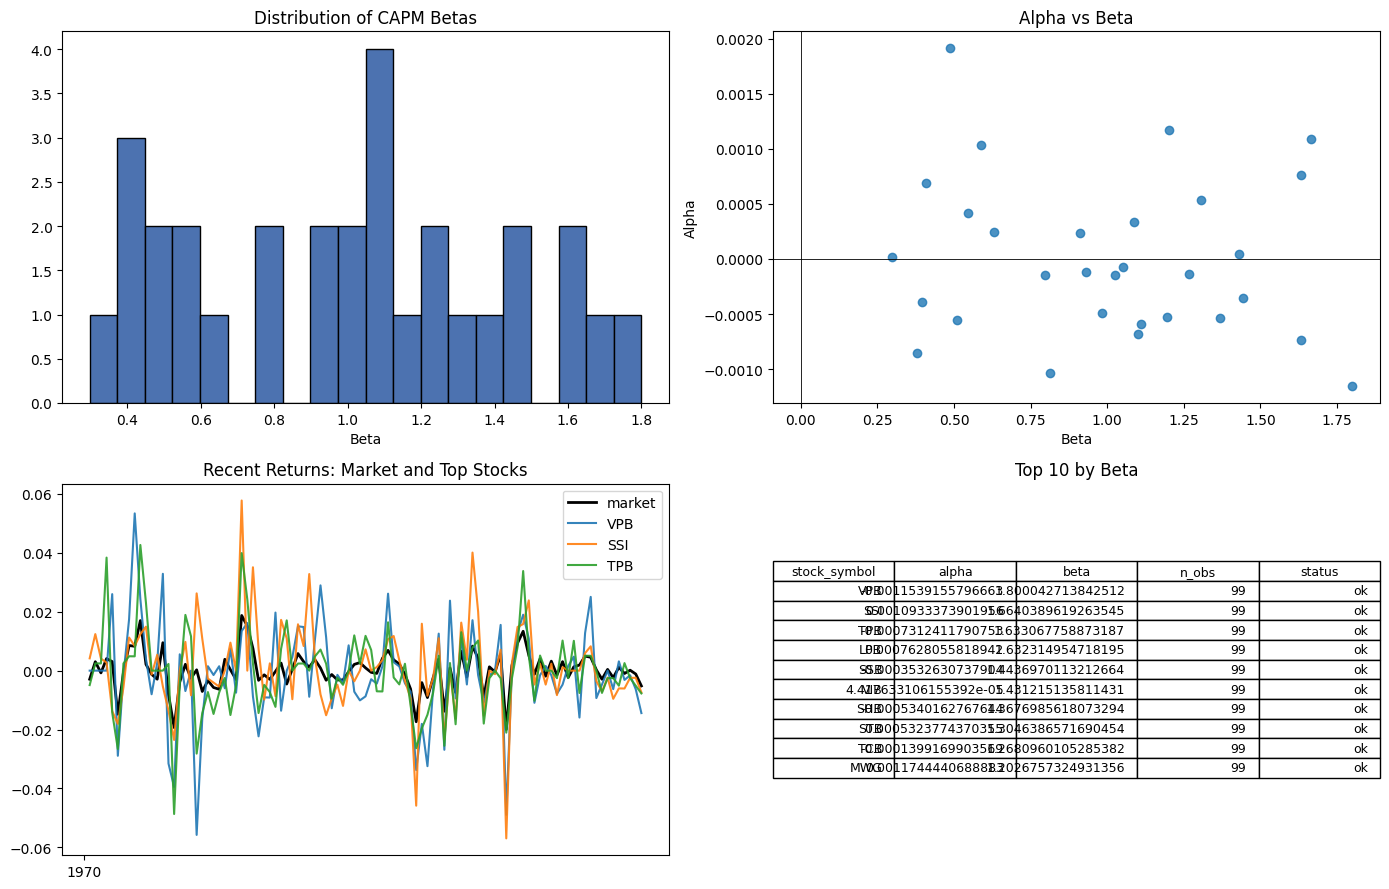

In [12]:
# Plot CAPM diagnostics: beta distribution, alpha vs beta, recent returns for top stocks
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

ROOT = Path('.')
res_file = ROOT / 'capm_results.csv'
if not res_file.exists():
    raise FileNotFoundError(f"Expected {res_file} to exist. Run the CAPM computation cell first.")

res = pd.read_csv(res_file)

if res.empty:
    print('No CAPM results to plot')
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    axes = axes.flatten()

    # 1) Histogram of betas
    betas = res['beta'].dropna()
    axes[0].hist(betas, bins=20, color='#4C72B0', edgecolor='k')
    axes[0].set_title('Distribution of CAPM Betas')
    axes[0].set_xlabel('Beta')

    # 2) Alpha vs Beta scatter
    axes[1].scatter(res['beta'], res['alpha'], alpha=0.8)
    axes[1].axvline(0, color='k', linewidth=0.6)
    axes[1].axhline(0, color='k', linewidth=0.6)
    axes[1].set_xlabel('Beta')
    axes[1].set_ylabel('Alpha')
    axes[1].set_title('Alpha vs Beta')

    # 3) Recent returns: market and top 3 by |beta|
    ok = res[res['status'] == 'ok'].dropna(subset=['beta'])
    if not ok.empty:
        top = ok.loc[ok['beta'].abs().sort_values(ascending=False).index].head(3)['stock_symbol'].tolist()
        # load vn30 prices and compute log returns
        price_csv = ROOT / 'vn30.csv'
        if price_csv.exists():
            df = pd.read_csv(price_csv, parse_dates=['timestamp'])
            price = df[['timestamp', 'stock_symbol', 'close']].pivot_table(index='timestamp', columns='stock_symbol', values='close')
            price = price.sort_index()
            returns = np.log(price).diff()
            market = returns.mean(axis=1)
            recent_index = market.dropna().index
            if len(recent_index) == 0:
                axes[2].text(0.5, 0.5, 'No return data to plot', ha='center')
            else:
                idx = recent_index[-200:] if len(recent_index) > 200 else recent_index
                axes[2].plot(market.loc[idx].index, market.loc[idx].values, label='market', linewidth=2, color='k')
                for s in top:
                    if s in returns.columns:
                        axes[2].plot(returns.loc[idx].index, returns.loc[idx, s].values, label=s, alpha=0.9)
                axes[2].legend()
                axes[2].set_title('Recent Returns: Market and Top Stocks')
        else:
            axes[2].text(0.5, 0.5, 'vn30.csv not found, cannot plot returns', ha='center')
    else:
        axes[2].text(0.5, 0.5, 'No stocks with valid beta to plot', ha='center')

    # 4) Summary table (show top rows)
    axes[3].axis('off')
    sample = res.sort_values('beta', ascending=False).head(10)[['stock_symbol', 'alpha', 'beta', 'n_obs', 'status']]
    table = axes[3].table(cellText=sample.values, colLabels=sample.columns, loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    axes[3].set_title('Top 10 by Beta')

    plt.tight_layout()
    out_fig = ROOT / 'capm_plots.png'
    plt.savefig(out_fig, dpi=150)
    print(f'CAPM plots saved to {out_fig}')
    plt.show()